100%|██████████| 9.91M/9.91M [00:02<00:00, 4.52MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 64.5kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.60MB/s]


Dataset sizes - Train: 55980 (80.0%), Validation: 4020 (5.7%), Test: 10000 (14.3%)
Total samples: 70000
Epoch: 1/30 | Train Loss: 1.4057, Train Acc: 83.54% | Val Loss: 0.7495, Val Acc: 92.81% | Sparsity: 0.00
Epoch: 2/30 | Train Loss: 0.6709, Train Acc: 95.23% | Val Loss: 0.6564, Val Acc: 95.62% | Sparsity: 0.03
Epoch: 3/30 | Train Loss: 0.6129, Train Acc: 97.11% | Val Loss: 0.6382, Val Acc: 96.52% | Sparsity: 0.05
Epoch: 4/30 | Train Loss: 0.5854, Train Acc: 97.85% | Val Loss: 0.6061, Val Acc: 97.34% | Sparsity: 0.08
Epoch: 5/30 | Train Loss: 0.5678, Train Acc: 98.30% | Val Loss: 0.5722, Val Acc: 98.11% | Sparsity: 0.11
Epoch: 6/30 | Train Loss: 0.5558, Train Acc: 98.49% | Val Loss: 0.5700, Val Acc: 97.99% | Sparsity: 0.13
Epoch: 7/30 | Train Loss: 0.5485, Train Acc: 98.67% | Val Loss: 0.5571, Val Acc: 98.41% | Sparsity: 0.16
Epoch: 8/30 | Train Loss: 0.5428, Train Acc: 98.77% | Val Loss: 0.5492, Val Acc: 98.48% | Sparsity: 0.19
Epoch: 9/30 | Train Loss: 0.5393, Train Acc: 98.82% | Va

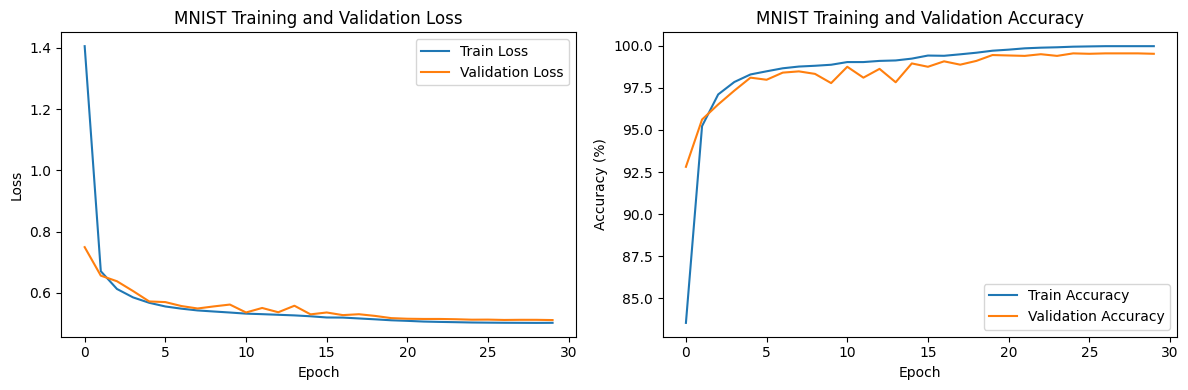


Final Results:
Final Training Loss: 0.5024
Final Validation Loss: 0.5114
Final Training Accuracy: 99.98%
Final Validation Accuracy: 99.53%
Final Test Loss: 0.5143
Final Test Accuracy: 99.44%


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# Define the basic block for ResNet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Define ResNet
class DynamicSparseResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):  # For MNIST, num_classes=10
        super(DynamicSparseResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(
            1, 64, kernel_size=3, stride=1, padding=1, bias=False  # Grayscale images have 1 channel
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []
        strides = [stride] + [1] * (num_blocks - 1)
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))  # Output size: 32x32
        out = self.layer1(out)                 # Output size: 32x32
        out = self.layer2(out)                 # Output size: 16x16
        out = self.layer3(out)                 # Output size: 8x8
        out = self.layer4(out)                 # Output size: 4x4
        out = F.avg_pool2d(out, 4)             # Output size: 1x1
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18(num_classes=10):
    return DynamicSparseResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)

def apply_dynamic_supermask(model, sparsity_rate):
    masks = {}
    for name, param in model.named_parameters():
        if 'weight' in name:
            weight_flat = param.data.abs().flatten()
            k = int(weight_flat.shape[0] * (1 - sparsity_rate))
            if k == 0:
                threshold = torch.max(weight_flat) + 1
            else:
                threshold = torch.topk(weight_flat, k, largest=True, sorted=True)[0][-1]
            mask = (param.data.abs() >= threshold).float()
            masks[name] = mask.view(param.size()).to(param.device)
    return masks

def dynamic_weight_update(model, masks):
    for name, param in model.named_parameters():
        if 'weight' in name and param.grad is not None:
            mask = masks[name]
            param.grad.data.mul_(mask)

def train_with_dynamic_pruning(model, train_loader, val_loader, test_loader, epochs=30, device='cuda'):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    initial_sparsity = 0.0
    final_sparsity = 0.8
    sparsity_increment = (final_sparsity - initial_sparsity) / epochs

    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []

    initialize_weights(model)

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        current_sparsity = initial_sparsity + sparsity_increment * epoch
        masks = apply_dynamic_supermask(model, current_sparsity)

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            dynamic_weight_update(model, masks)
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_accuracy = 100.0 * correct / total

        # Validation
        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_acc.append(train_accuracy)
        val_acc.append(val_accuracy)

        scheduler.step()

        print(
            f"Epoch: {epoch+1}/{epochs}"
            f" | Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%"
            f" | Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%"
            f" | Sparsity: {current_sparsity:.2f}"
        )

    # Final evaluation on the test set
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
    print(f"\nTest Set Evaluation: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")

    return train_losses, val_losses, train_acc, val_acc, test_loss, test_accuracy

def evaluate(model, data_loader, criterion, device):
    model.eval()
    loss_total = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss_total += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = loss_total / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

def main():
    torch.manual_seed(42)

    # Define transformations for MNIST dataset
    transform_train = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # Mean and std for MNIST
    ])

    transform_test = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # Mean and std for MNIST
    ])

    # Load the MNIST dataset
    train_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, download=True, transform=transform_train
    )

    test_dataset = torchvision.datasets.MNIST(
        root='./data', train=False, download=True, transform=transform_test
    )

    # For a proper 80/10/10 split:
    # MNIST has 60,000 training samples and 10,000 test samples (total 70,000)
    # 80% would be 56,000, 10% would be 7,000 samples each
    # Since we want to keep the test set as-is, we need to:
    # - Use 56,000/60,000 = 93.3% of the training set for training
    # - Use 4,000/60,000 = 6.7% of the training set for validation
    # - Keep the original 10,000 test samples

    # Calculate split sizes
    train_size = int(0.933 * len(train_dataset))  # ~56,000 samples (93.3% of training)
    val_size = len(train_dataset) - train_size    # ~4,000 samples (6.7% of training)

    train_subset, val_subset = torch.utils.data.random_split(
        train_dataset, [train_size, val_size]
    )

    # Display dataset sizes
    total_samples = len(train_subset) + len(val_subset) + len(test_dataset)
    print(f"Dataset sizes - Train: {len(train_subset)} ({len(train_subset)/total_samples*100:.1f}%), "
          f"Validation: {len(val_subset)} ({len(val_subset)/total_samples*100:.1f}%), "
          f"Test: {len(test_dataset)} ({len(test_dataset)/total_samples*100:.1f}%)")
    print(f"Total samples: {total_samples}")

    # Set up DataLoader for training, validation, and testing data
    batch_size = 128
    train_loader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
    )

    val_loader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )

    # Set device to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ResNet18(num_classes=10).to(device)

    # Train and validate the model with dynamic pruning
    train_losses, val_losses, train_acc, val_acc, test_loss, test_accuracy = train_with_dynamic_pruning(
        model, train_loader, val_loader, test_loader, epochs=30, device=device
    )

    # Plot training results
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('MNIST Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('MNIST Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

    # Print final metrics
    print("\nFinal Results:")
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Validation Loss: {val_losses[-1]:.4f}")
    print(f"Final Training Accuracy: {train_acc[-1]:.2f}%")
    print(f"Final Validation Accuracy: {val_acc[-1]:.2f}%")
    print(f"Final Test Loss: {test_loss:.4f}")
    print(f"Final Test Accuracy: {test_accuracy:.2f}%")

if __name__ == "__main__":
    main()